In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

from statsmodels.stats.multitest import multipletests

# Load and aggregate all three tables (ExE, NxN, NxE)

In [2]:
def preprocess_data(path):
    ee = pd.read_csv('../../../../../../s/project/yeast_gxg/data/constanzo2016/'+path, sep='\t')
    ee.columns = ee.columns.str.replace(' ', '_')
    
    ee['query_gene'] = ee.Query_Strain_ID.str.split('_',expand=True)[0]
    ee['array_gene'] = ee.Array_Strain_ID.str.split('_',expand=True)[0]
    ee['temp'] = ee['Arraytype/Temp'].str[-2:]
    
    ee['dmf'] = ee['Double_mutant_fitness']
    ee['gi_score'] = ee['Genetic_interaction_score_(ε)']
    
    ee['smf_q'] = ee['Query_single_mutant_fitness_(SMF)']
    ee['smf_a'] = ee['Array_SMF']
    ee['smf_qxa'] = ee['smf_q'] * ee['smf_a']
    ee = ee[['query_gene', 'array_gene', 'dmf', 'gi_score', 'P-value', 'temp', 'smf_q', 'smf_a', 'smf_qxa']]
    
    return ee

In [3]:
pathes_constanzo = ['SGA_ExE.txt', 'SGA_NxN.txt', 'SGA_ExN_NxE.txt']
ee = preprocess_data(pathes_constanzo[0])
nn = preprocess_data(pathes_constanzo[1])
en = preprocess_data(pathes_constanzo[2])

In [4]:
essential_genes = list(set(ee.query_gene.unique()) | set(ee.array_gene.unique()))
#nonessential_genes = list(set(nn.query_gene.unique()) | set(nn.array_gene.unique()))

In [5]:
ee.head()

,query_gene,array_gene,dmf,gi_score,P-value,temp,smf_q,smf_a,smf_qxa
0,YAL001C,YBL023C,0.7319,-0.0348,0.005042,30,0.8285,0.9254,0.766694
1,YAL001C,YBL026W,0.4266,-0.3529,0.000004,30,0.8285,0.9408,0.779453
2,YAL001C,YBL034C,0.7520,0.0126,0.462500,30,0.8285,0.8925,0.739436
3,YAL001C,YBL034C,0.6661,0.0043,0.499800,30,0.8285,0.7988,0.661806
4,YAL001C,YBL034C,0.4764,-0.1601,0.051400,30,0.8285,0.7683,0.636537


Let's now not care about temperature and just select the measurement with the lowest p-value?

In [6]:
ee.temp.value_counts()

temp
26    815635
30      2935
Name: count, dtype: int64

In [7]:
nn.temp.value_counts()

temp
30    12280559
26      418380
Name: count, dtype: int64

In [8]:
en.temp.value_counts()

temp
26    4197250
30    1598895
Name: count, dtype: int64

In [9]:
def correction(ee):
    reject, pvals_corrected, _, _ = multipletests(ee['P-value'], method = 'bonferroni')
    ee['P-value-bonferroni'] = pvals_corrected
    reject, pvals_corrected, _, _ = multipletests(ee['P-value'], method = 'fdr_bh')
    ee['P-value-bh'] = pvals_corrected
    return ee

In [10]:
ee = correction(ee)

In [11]:
ee.head()

,query_gene,array_gene,dmf,gi_score,P-value,temp,smf_q,smf_a,smf_qxa,P-value-bonferroni,P-value-bh
0,YAL001C,YBL023C,0.7319,-0.0348,0.005042,30,0.8285,0.9254,0.766694,1.0,0.032588
1,YAL001C,YBL026W,0.4266,-0.3529,0.000004,30,0.8285,0.9408,0.779453,1.0,0.000053
2,YAL001C,YBL034C,0.7520,0.0126,0.462500,30,0.8285,0.8925,0.739436,1.0,0.496629
3,YAL001C,YBL034C,0.6661,0.0043,0.499800,30,0.8285,0.7988,0.661806,1.0,0.500746
4,YAL001C,YBL034C,0.4764,-0.1601,0.051400,30,0.8285,0.7683,0.636537,1.0,0.187847


In [12]:
ee[ee['P-value-bonferroni']<0.05].shape

(42359, 11)

In [13]:
df = []
for dataset in [ee, nn, en]:
    dataset = correction(dataset)
    df.append([dataset.shape[0],dataset[dataset['P-value']<0.05].shape[0],dataset[dataset['P-value-bh']<0.05].shape[0], dataset[dataset['P-value-bonferroni']<0.05].shape[0] ])

In [14]:
pd.DataFrame(df, columns = ['Initial', 'p_val_0.05','bh', 'bonferroni'], index = ['ExE', 'NxN', 'ExN_NxE'])

,Initial,p_val_0.05,bh,bonferroni
ExE,818570,221971,140393,42359
NxN,12698939,1498451,617685,168963
ExN_NxE,5796145,912495,428525,117767


In [15]:
ee['genes'] = 'ExE'
nn['genes'] = 'NxN'
en['genes'] = 'ExN_NxE'

In [16]:
dfs = []
for dataset in [ee, nn, en]:
    dataset_corr = dataset[dataset['P-value-bh']<0.05]
    dfs.append(dataset_corr.groupby(['query_gene', 'array_gene', 'genes']).min('P-value-corr'))

In [17]:
concat_df = pd.concat(dfs).reset_index()

In [18]:
concat_df

,query_gene,array_gene,genes,dmf,gi_score,P-value,smf_q,smf_a,smf_qxa,P-value-bonferroni,P-value-bh
0,YAL001C,YBL023C,ExE,0.7319,-0.0348,5.042000e-03,0.8285,0.9254,0.766694,1.000000e+00,3.258794e-02
1,YAL001C,YBL026W,ExE,0.4266,-0.3529,3.591000e-06,0.8285,0.9408,0.779453,1.000000e+00,5.324479e-05
2,YAL001C,YBL076C,ExE,0.6458,-0.0250,1.301000e-04,0.8285,0.8097,0.670836,1.000000e+00,1.398227e-03
3,YAL001C,YBL097W,ExE,0.3719,-0.0808,5.582000e-15,0.8285,0.5464,0.452692,4.569258e-09,2.041853e-13
4,YAL001C,YBR029C,ExE,0.6289,-0.1173,8.243000e-05,0.8285,0.9007,0.746230,1.000000e+00,9.297881e-04
...,...,...,...,...,...,...,...,...,...,...,...
1122249,YPR202W,YOR262W,ExN_NxE,0.6732,-0.1490,3.462000e-06,1.0095,0.8145,0.822238,1.000000e+00,1.135933e-04
1122250,YPR202W,YPL007C,ExN_NxE,0.8877,-0.0572,4.619000e-04,1.0095,0.9360,0.944892,1.000000e+00,8.908808e-03
1122251,YPR202W,YPL076W,ExN_NxE,0.8590,0.0695,1.863000e-03,1.0095,0.7821,0.789530,1.000000e+00,2.873609e-02
1122252,YPR202W,YPL169C,ExN_NxE,0.8677,0.0567,2.518000e-03,1.0095,0.8034,0.811032,1.000000e+00,3.674431e-02


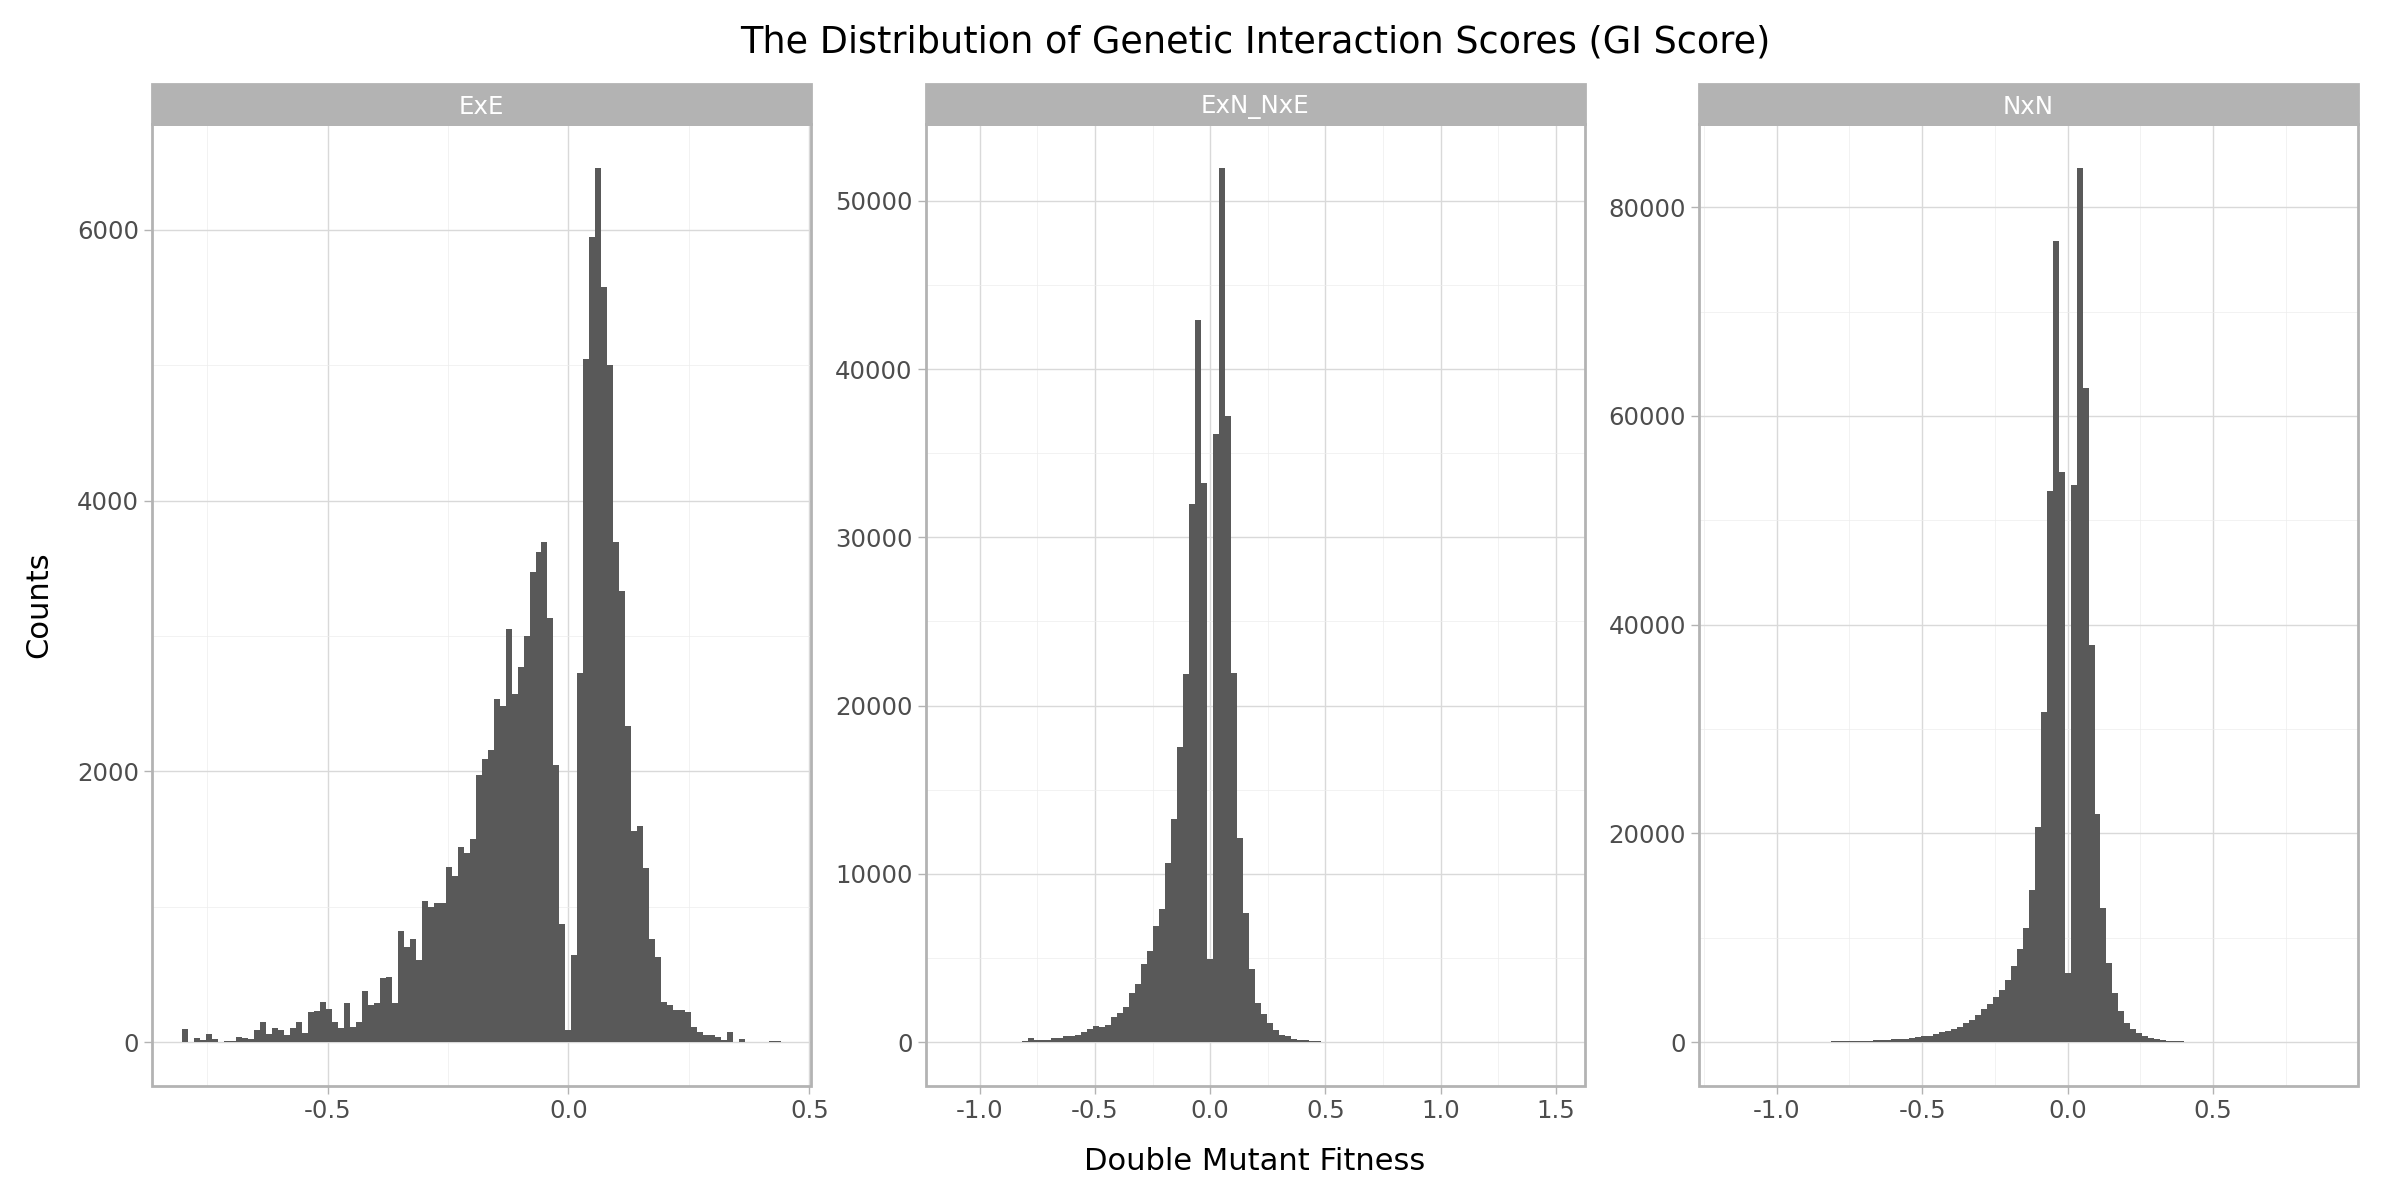

In [30]:
(
    p9.ggplot(concat_df, p9.aes(x="gi_score"))
    + p9.geom_histogram(bins = 100)
    + p9.facet_wrap("genes", scales='free')
    +p9.labs(
        x="Double Mutant Fitness",
        y="Counts",
        title="The Distribution of Genetic Interaction Scores (GI Score)",
    )
    +p9.theme_light()
    +p9.theme(figure_size=(12, 6))  
)



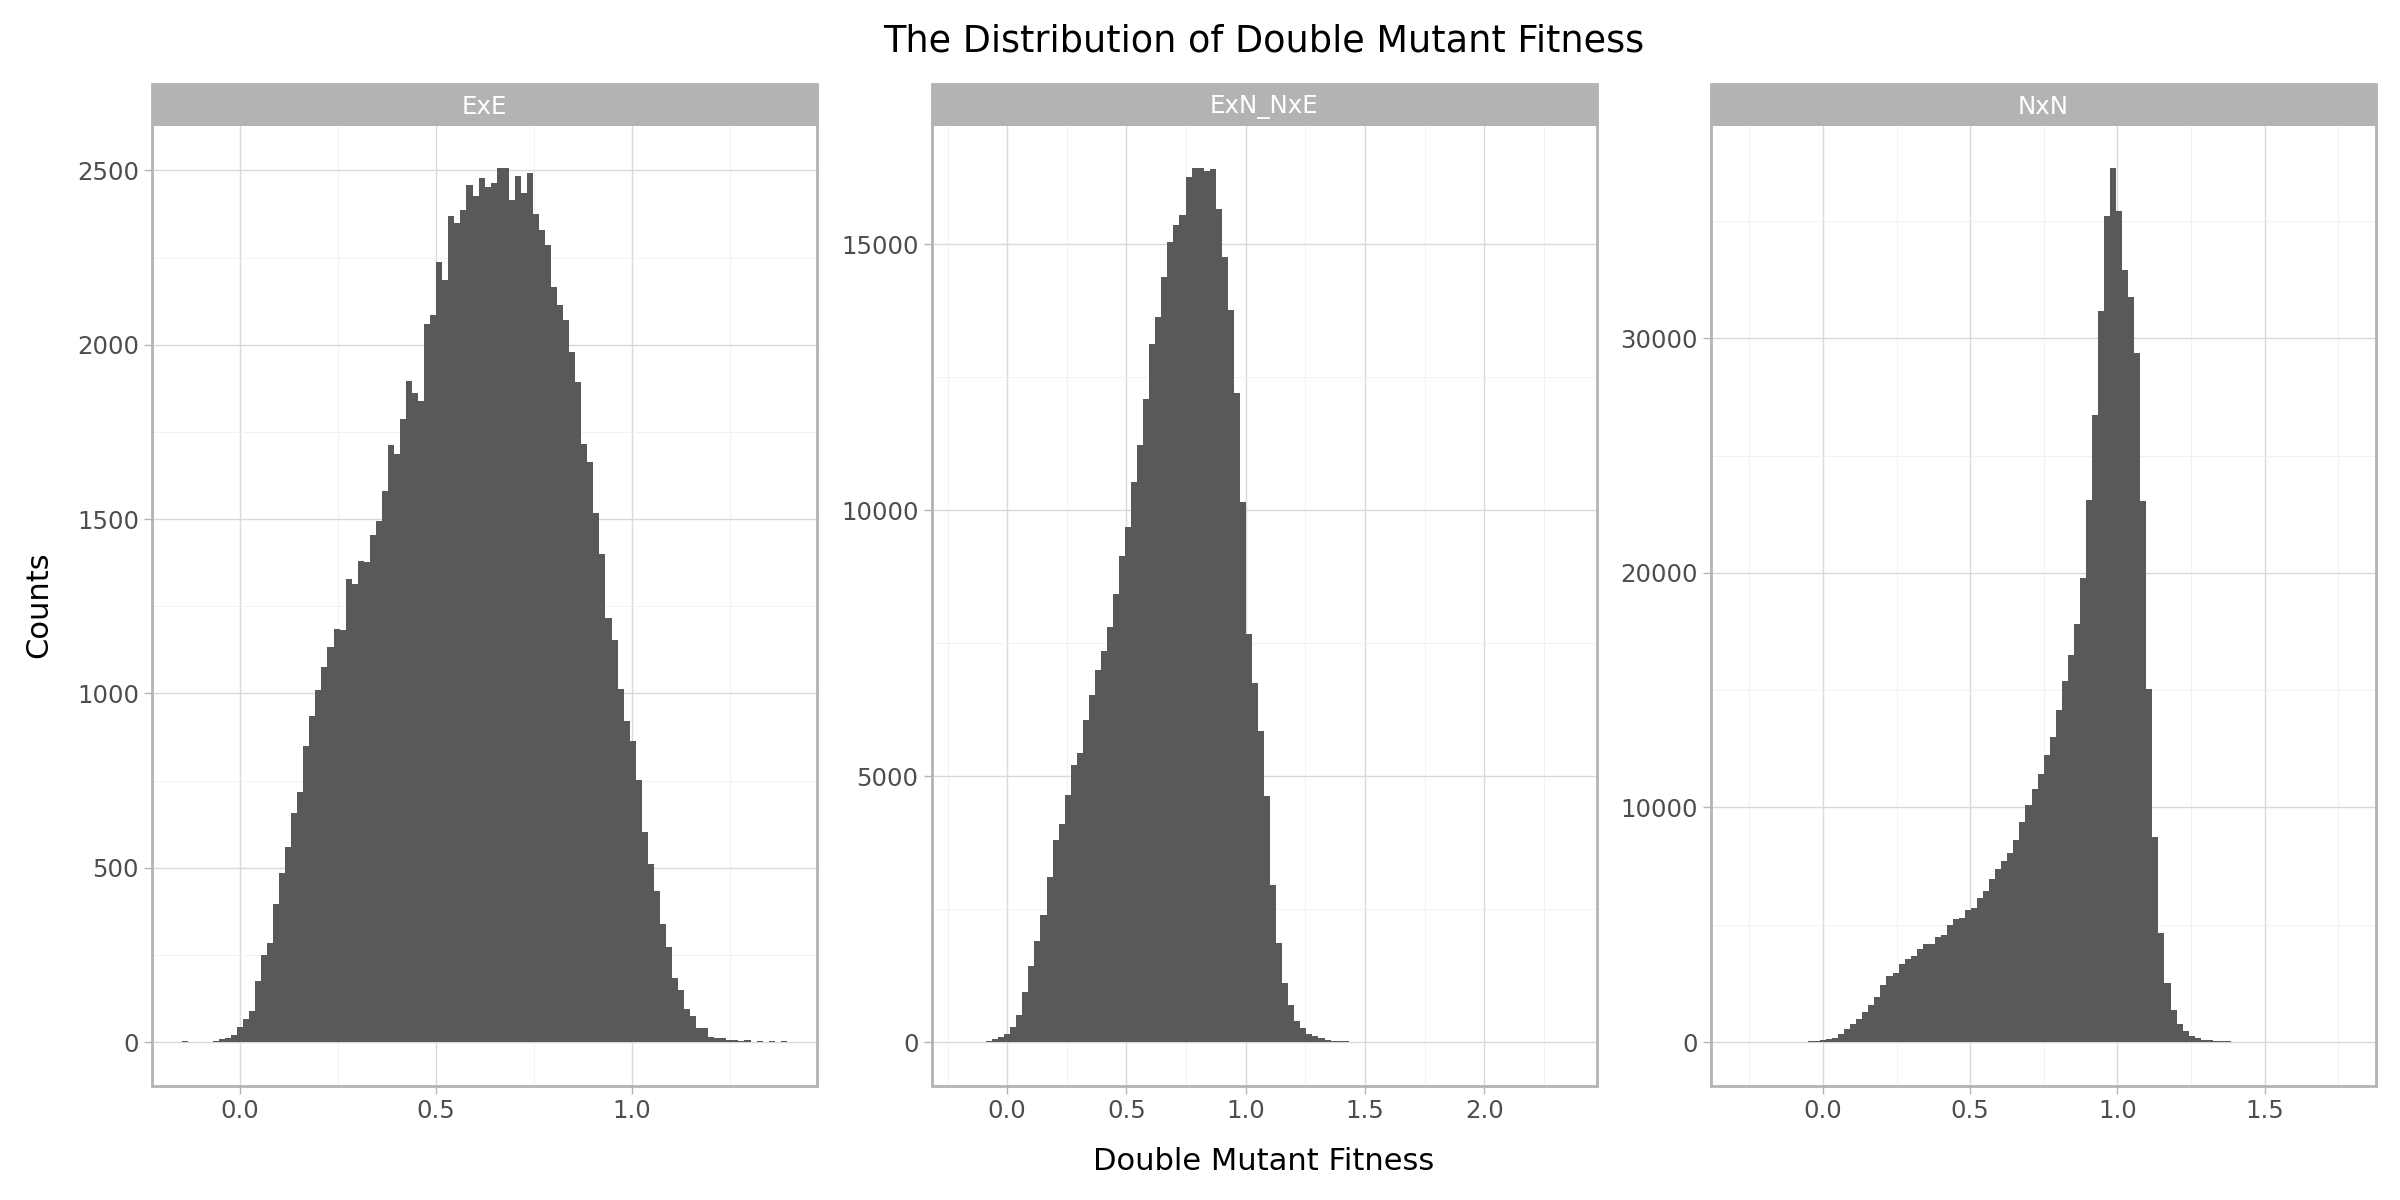

In [31]:
(
    p9.ggplot(concat_df, p9.aes(x="dmf"))
    + p9.geom_histogram(bins = 100)
    + p9.facet_wrap("genes", scales='free')
    +p9.labs(
        x="Double Mutant Fitness",
        y="Counts",
        title="The Distribution of Double Mutant Fitness",
    )
    +p9.theme_light()
    +p9.theme(figure_size=(12, 6))  
)

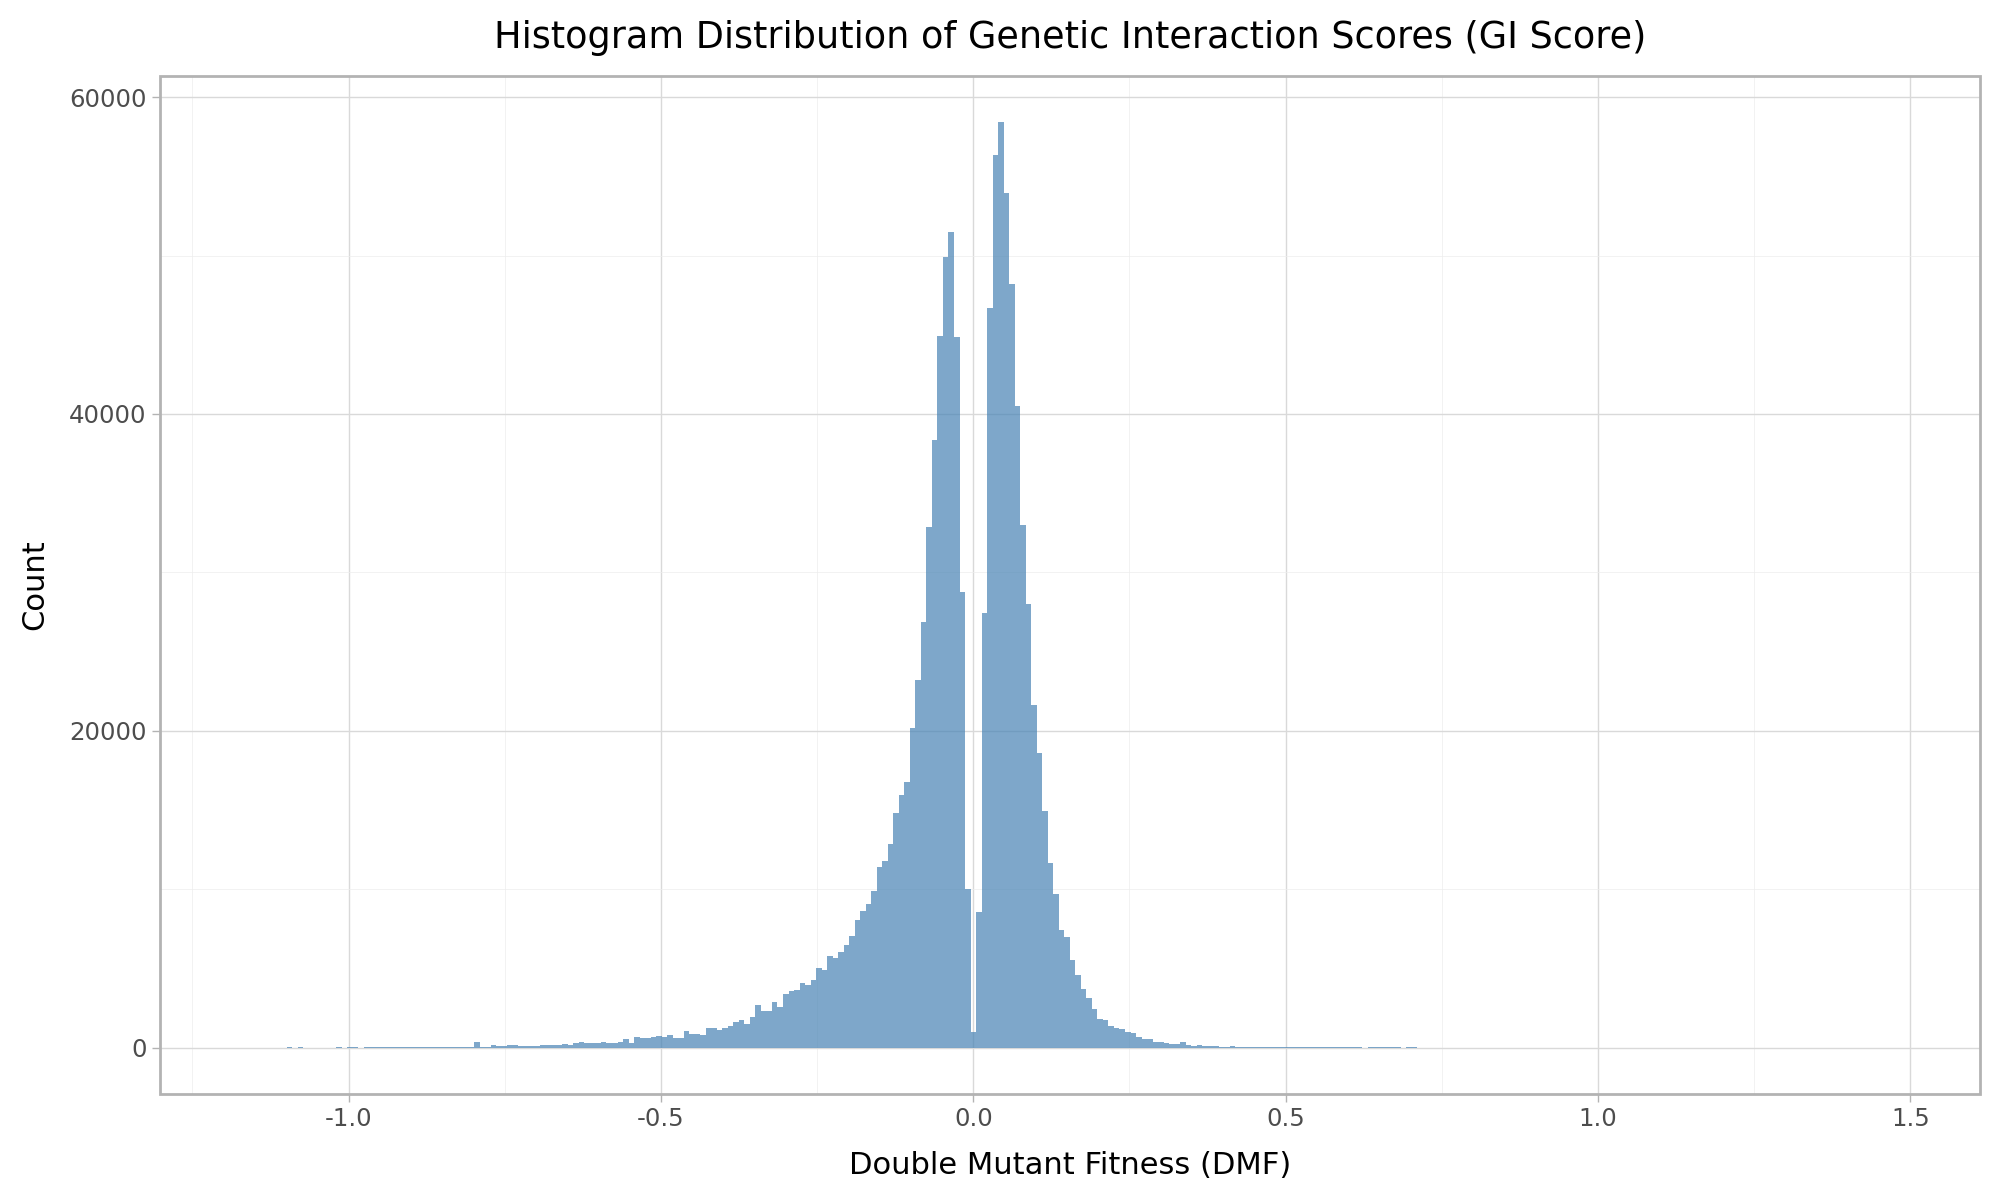

In [32]:
(
    p9.ggplot(concat_df, p9.aes(x="gi_score"))
    + p9.geom_histogram(bins=300, alpha=0.7, fill="steelblue")
    + p9.labs(
        x="Double Mutant Fitness (DMF)",
        y="Count",
        title="Histogram Distribution of Genetic Interaction Scores (GI Score)"
    )
    + p9.theme_light()
    + p9.theme(figure_size=(10, 6))
)

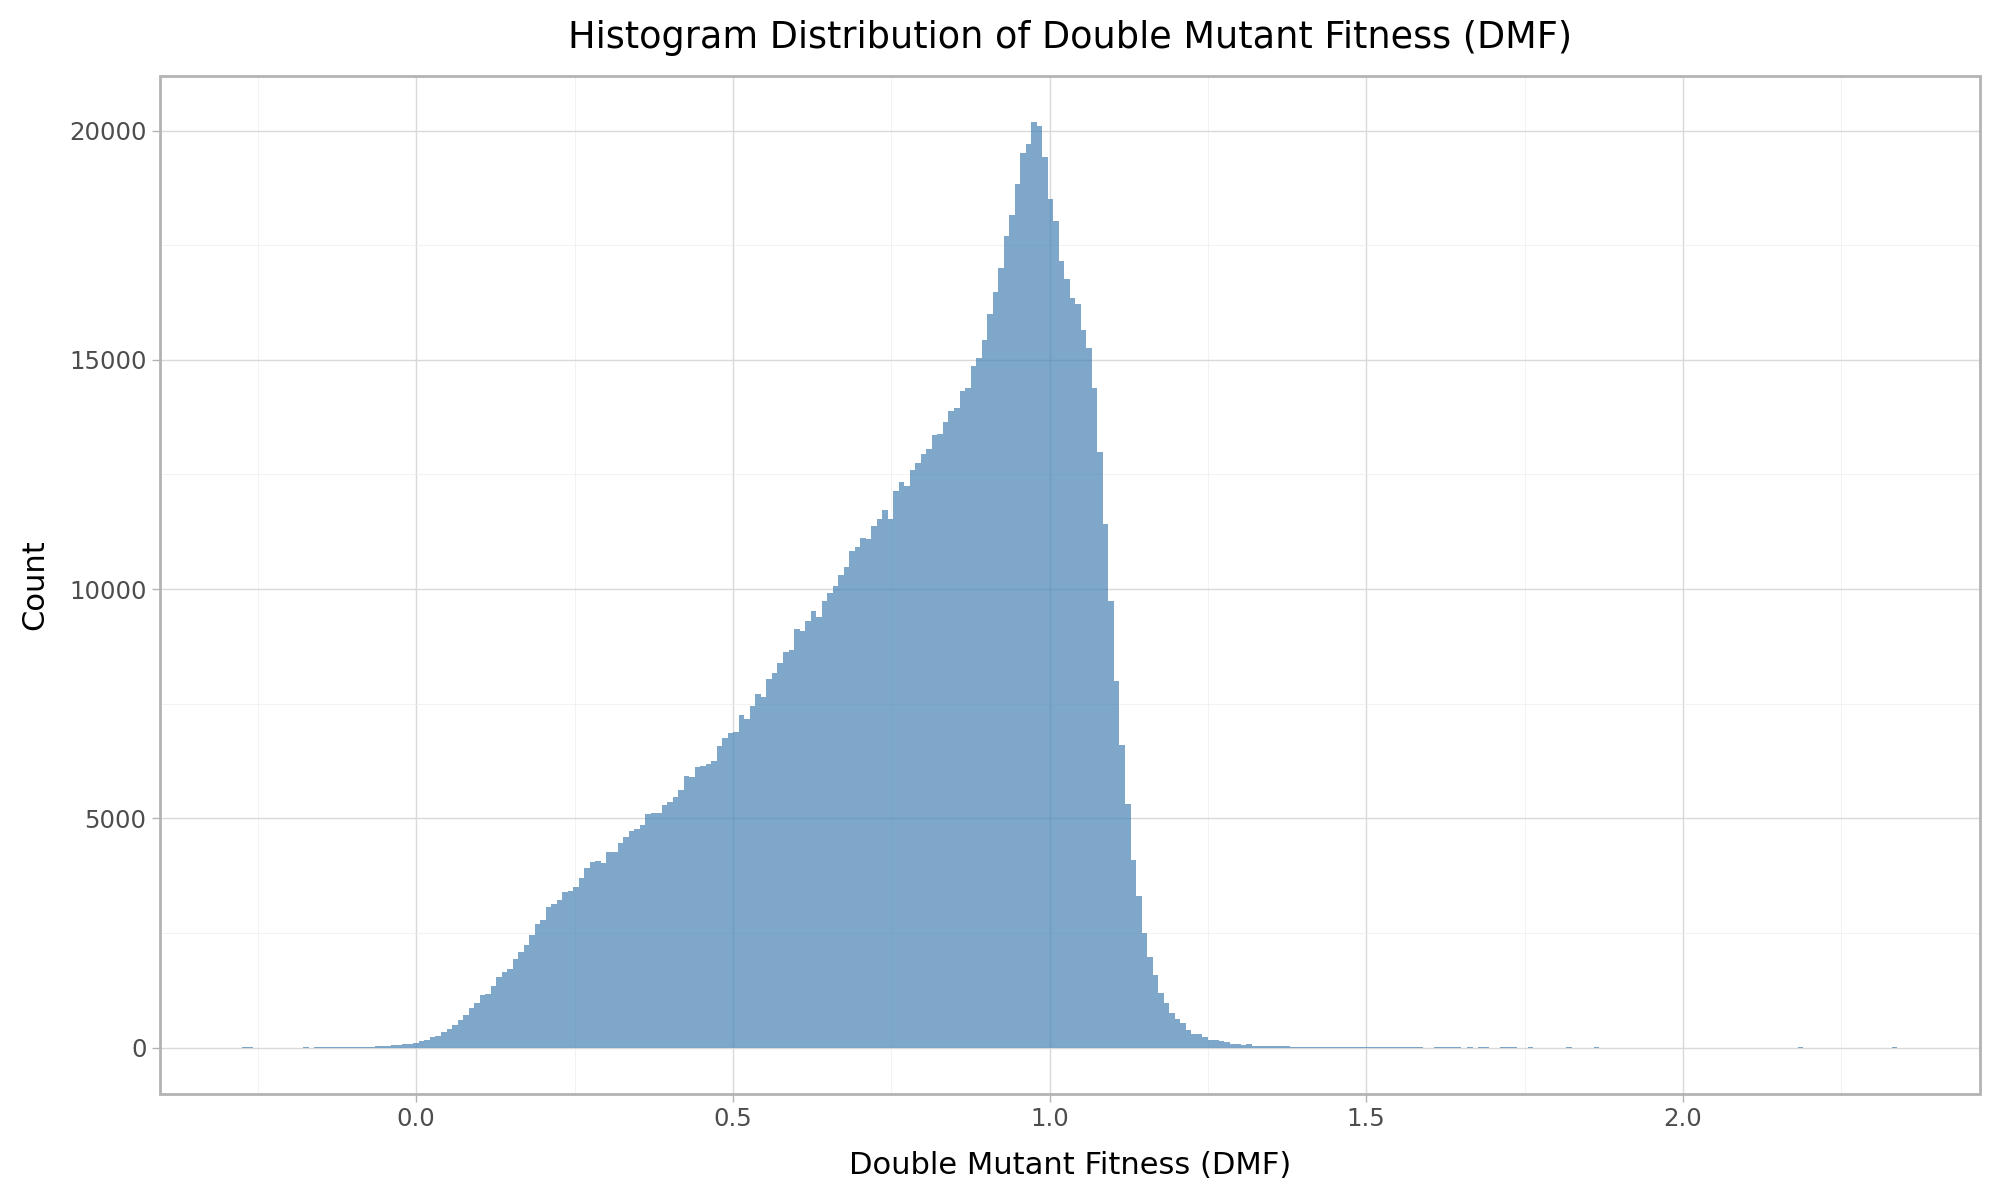

In [33]:
(
    p9.ggplot(concat_df, p9.aes(x="dmf"))
    + p9.geom_histogram(bins=300, alpha=0.7, fill="steelblue")
    + p9.labs(
        x="Double Mutant Fitness (DMF)",
        y="Count",
        title="Histogram Distribution of Double Mutant Fitness (DMF)"
    )
    + p9.theme_light()
    + p9.theme(figure_size=(10, 6))
)

In [20]:
concat_df[["query_gene", "array_gene", "gi_score", "dmf"]].to_csv("../extracted_data/interaction_table_all.csv")
ee[["query_gene", "array_gene", "gi_score", "dmf"]].to_csv("../extracted_data/interaction_table_ee.csv")
nn[["query_gene", "array_gene", "gi_score", "dmf"]].to_csv("../extracted_data/interaction_table_nn.csv")
en[["query_gene", "array_gene", "gi_score", "dmf"]].to_csv("../extracted_data/interaction_table_en.csv")

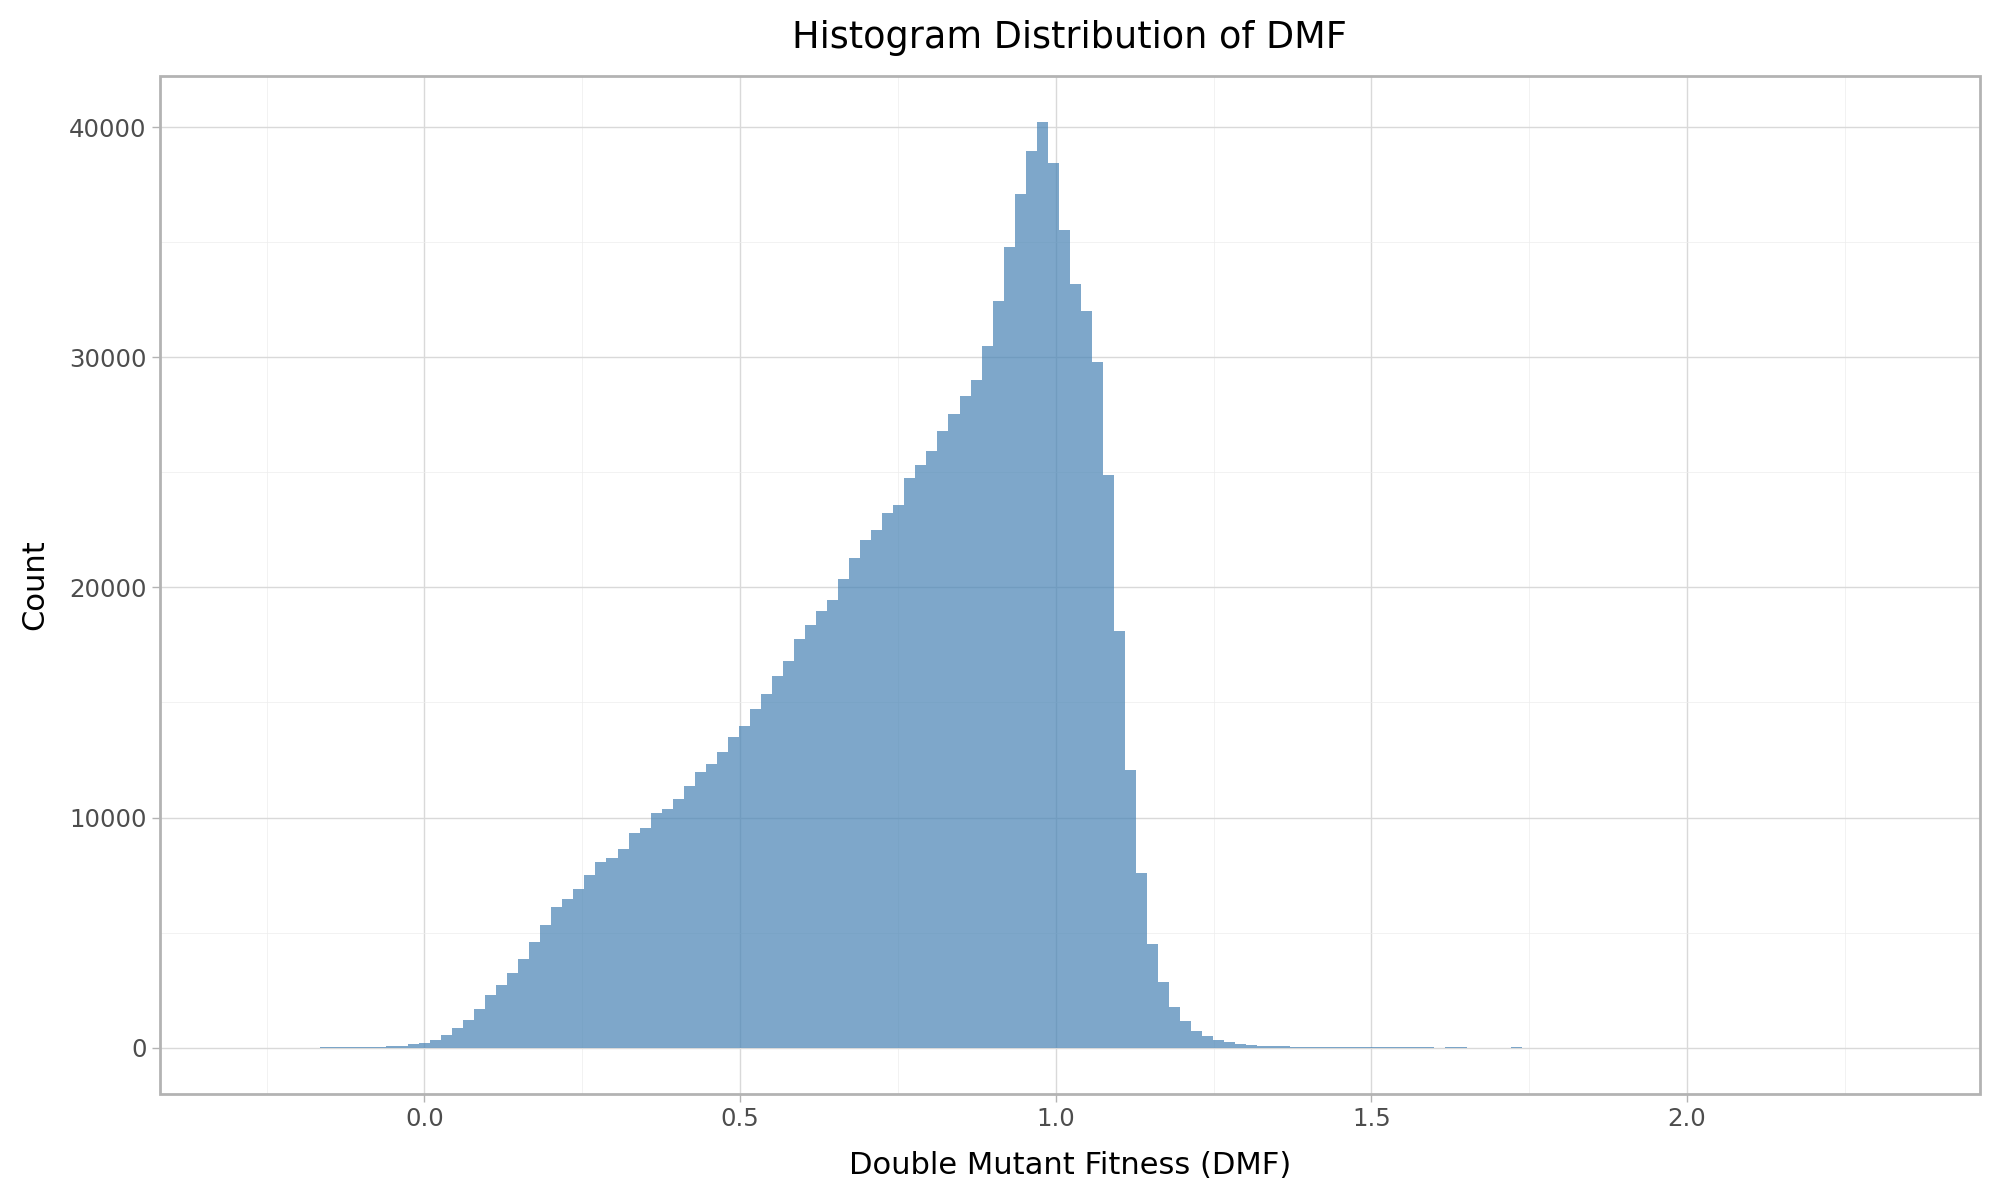